수정일: 2025.10.26

# HW5: Image Classification

이번 과제에서는 CNN을 이용해 CIFAR-10 데이터셋의 이미지를 분류해 보겠다. 모델 정의를 제외한 전반 적인 과정은 이전 과제와 유사하다.

**이번 과제에서는 GPU를 이용한다. 이를 위해서는 메뉴의 [런타임]-[런타임 유형 변경]에서 '하드웨어 가속기'를 'T4 GPU'로 선택해야 한다.**

우선 필요한 모듈을 불러오고, 필요한 셋팅을 한다.

In [1]:
import numpy as np # NumPy
import matplotlib.pyplot as plt # Matplotlib

import torch # PyTorch
import torchvision # 데이터셋을 읽기 위해 필요
import torchvision.transforms as transforms # 데이터셋을 읽기 위해 필요
from torch import nn # PyTorch 레이어

## CIFAR-10 데이터셋

[CIFAR-10 데이터셋](https://www.cs.toronto.edu/~kriz/cifar.html)은 60,000개의 컬러 이미지로 구성된 데이터셋이다. 각각의 이미지는 32x32 크기의 3채널로 구성되어 있다. 그리고, 이미지는 10개의 클래스로 분류되며, 각 클래스 당 6,000개의 이미지로 구성된다. 이 중, training set은 50,000개이며 test set은 10,000개이다. 그러나, validation을 위해 training set 중 10,000개를 이용할 것이다.

아래 코드는 인터넷에서 CIFAR-10 데이터셋을 다운로드 받아 저장한다. 이는 [torchvision.datasets.CIFAR10](https://pytorch.org/vision/stable/datasets.html#cifar)를 이용하면 쉽게 할 수 있다. Validation set을 분리하는 것은 [torch.utils.data.dataset.random_split](https://pytorch.org/docs/stable/data.html?highlight=random_split#torch.utils.data.random_split)을 이용한다.

In [2]:
transform = transforms.Compose([transforms.ToTensor()]) # 불러온 이미지를 tensor로 변환해준다.

dataset = torchvision.datasets.CIFAR10('dataset', train=True, download=True, transform=transform) # training set을 다운로드 한다.
testset = torchvision.datasets.CIFAR10('dataset', train=False, download=True, transform=transform) # test set을 다운로드 한다.

trainset, validationset = torch.utils.data.dataset.random_split(dataset, [40000, 10000]) # training set을 다시 40000개와 10000개로 분할한다.

# 각 클래스에 대한 이름을 저장한 리스트를 만든다.
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

100%|██████████| 170M/170M [01:36<00:00, 1.76MB/s]


CIFAR-10 데이터셋의 기본 정보를 출력한다. 이 때, 이미지의 크기가 32x32x3인 것을 확인하고, 각 픽셀의 값이 0에서 1 사이의 값을 갖는 것을 확인한다. 그리고, 레이블 정보는 0~9 사이의 정수로 저장되어 있다.

**PyTorch는 이미지를 처리할 때 (채널, 세로, 가로) 순서로 데이터를 표현한다. 수업 시간에는 (가로, 세로, 채널) 순서로 표현했다는 점에 주의해야 한다.**

In [3]:
print("Traning set 개수:", len(trainset)) # 40,000개
print("Validation set 개수:", len(validationset)) # 10,000개
print("Test set 개수:", len(testset)) # 10,000개

# trainset의 데이터를 가져온다. 이 때, x에는 입력 데이터(즉, 숫자 이미지)가, y에는 입력 데이터에 대한 출력 데이터(즉, 레이블)이 저장된다.
for x, y in trainset:
  print("Shape of x:", x.shape) # [3, 32, 32] (채널수, 세로 크기, 가로 크기)
  print("x:", x) # 각 픽셀이 0~1 사이의 값을 갖는 것을 확인
  print("Label:", y) # 0~9 사이의 값
  print("Class:", classes[y]) # 레이블에 해당하는 클래스 이름
  break # 한 개에 대해서만 출력하고 종료

Traning set 개수: 40000
Validation set 개수: 10000
Test set 개수: 10000
Shape of x: torch.Size([3, 32, 32])
x: tensor([[[0.6980, 0.6431, 0.5529,  ..., 0.4392, 0.4314, 0.3961],
         [0.6510, 0.6157, 0.5098,  ..., 0.4039, 0.4000, 0.3922],
         [0.5882, 0.5725, 0.4980,  ..., 0.5137, 0.4667, 0.4275],
         ...,
         [0.4118, 0.4078, 0.4078,  ..., 0.5020, 0.5020, 0.5176],
         [0.3843, 0.3647, 0.3843,  ..., 0.4157, 0.4118, 0.4353],
         [0.4000, 0.4196, 0.4706,  ..., 0.4863, 0.4549, 0.4235]],

        [[0.7529, 0.7216, 0.6824,  ..., 0.6667, 0.6627, 0.6510],
         [0.7137, 0.6941, 0.6549,  ..., 0.6588, 0.6510, 0.6510],
         [0.6902, 0.6824, 0.6549,  ..., 0.7176, 0.6863, 0.6706],
         ...,
         [0.3922, 0.4000, 0.4039,  ..., 0.5176, 0.5216, 0.5529],
         [0.3647, 0.3529, 0.3765,  ..., 0.4314, 0.4275, 0.4667],
         [0.3804, 0.4039, 0.4588,  ..., 0.4980, 0.4745, 0.4510]],

        [[0.8392, 0.8314, 0.8353,  ..., 0.8824, 0.8784, 0.8667],
         [0.8275, 

CIFAR-10 데이터셋의 일부 이미지를 출력해본다.

PyTorch는 이미지를 (채널, 세로, 가로) 순서로 표현하지만, MatplotLib나 다른 이미지 처리 라이브러리들은 (가로, 세로, 채널) 순서로 표현하는 경우가 많다. 여기서도 이미지를 MatplotLib로 가시화하기 위해서는 (가로, 세로, 채널) 순서로 변환해 줘야 한다.

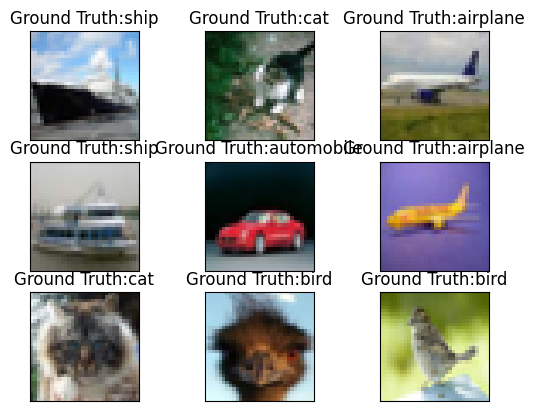

In [4]:
_, axes = plt.subplots(3, 3)

for i, (x, y) in enumerate(trainset):
  img = np.transpose(x, (1, 2, 0)) # (채널, 세로, 가로) 형태를 (가로, 세로, 채널)로 변환

  row = i // 3
  col = i % 3
  ax = axes[row, col]

  ax.imshow(img, interpolation='none') # 이미지를 표시한다.
  ax.set_title("Ground Truth:" + classes[y])
  ax.set_xticks([])
  ax.set_yticks([])

  if i >= 8: # 9개의 이미지만 보여준다.
    break

plt.show()

## 모델 정의

CIFAR-10 데이터셋을 분류하기 위한 CNN 모델을 정의한다.

지난 과제에서와 같이 CNN 모델을 정의하기 위해 [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)에서 상속받은 클래스를 정의한다. 그리고 *\_\_init\_\_()* 함수 안에 네트워크의 레이어들을 정의하고, *forward()* 함수 안에서 정의한 레이어들을 연결해 준다.

Convolution 레이어는 [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)를 이용한다. 활성화 함수는 [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)를 이용한다. 그리고 Max Pooling 레이어는 [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)를 이용한다.

추가적으로 overfitting을 줄이기 위해 dropout 레이어([nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html))를 추가해본다. 이 때, dropout rate은 hyperparameter이다.

이번 과제에서는 좋은 성능을 가지도록 **여러분이 직접 레이어를 정의**한다. 레이어는 다음과 같은 형태로 구성해야 한다.

Conv2d -> ReLU -> MaxPool2d -> Dropout -> Conv2d -> ReLU -> MaxPool2d -> Dropout -> Conv2d -> ... -> MaxPool2d -> Dropout ->  Flatten -> Linear -> ReLU -> -> Dropout Linear -> ReLU -> ... -> Linear

위에서와 같이 마지막 레이어는 nn.Linear가 되어야 한다. (Dropout을 추가하지 않는다.)

**지시: 좋은 성능을 낼 수 있게 다음 CNN 모델을 정의한다.**

In [5]:
class Cifar10Model(nn.Module): # nn.Module을 상속받은 클래스를 정의. 이름을 Cifar10Model로 정의하였다.
  def __init__(self): # 이 안에 레이어들을 정의한다.
    super(Cifar10Model, self).__init__()

    ## 아래 코드를 적절히 수정하시오.
    #### 코드 시작 ####
    self.conv_layer1 = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # (3, 32, 32) -> (32, 32, 32)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), # (32, 32, 32) -> (32, 16, 16)
      nn.Dropout(p=0.5)
    )

    self.conv_layer2 = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (32, 16, 16) -> (64, 16, 16)
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2), # (64, 16, 16) -> (64, 8, 8)
      nn.Dropout(p=0.5)
    )

    self.flatten = nn.Flatten()

    self.fc_layers = nn.Sequential(
      nn.Linear(64 * 8 * 8, 512),
      nn.ReLU(),
      nn.Dropout(p=0.5),
      nn.Linear(512, 10)
    )
    #### 코드 종료 ####

  def forward(self, x): # 이 안에 레이어들을 연결해준다.
    ## 아래 코드를 적절히 수정하시오.
    #### 코드 시작 ####
    x = self.conv_layer1(x)
    x = self.conv_layer2(x)
    x = self.flatten(x)
    x = self.fc_layers(x)
    #### 코드 종료 ####
    return x

model = Cifar10Model().cuda() # GPU에 모델 생성

## 학습

학습을 위해 하이퍼파라미터를 설정한다. 이번 과제에서는 여러분이 직접 하이퍼파라미터를 설정한다.

**지시: 좋은 성능을 낼 수 있게 아래 hyperparameter를 조정한다.**

In [6]:
# Hyperparameter를 설정한다.
# 사용자가 변경할 수 있다.
epochs = 50 # 최대 epoch
learning_rate = 0.001 # Learning rate
batch_size = 128 # Batch size

데이터를 batch size 단위로 나누어 불러올 수 있게 [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)를 사용한다. Training set과 validation set 모두에 대해 각각의 DataLoader를 만들어준다.

In [7]:
# shuffle=True는 데이터를 불러올 때, 데이터를 섞어준다.
trainset_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
validationset_loader = torch.utils.data.DataLoader(dataset=validationset, batch_size=batch_size, shuffle=True)

Optimizer를 정의한다. 여기서는 [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) 알고리즘을 이용해 batch size 단위로 최적화를 한다.

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Loss function을 정의한다. 여기서는 PyTorch가 제공하는 [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)를 사용한다. 이는 자체적으로 softmax 함수를 포함하므로, 모델에 softmax 활성화 함수를 별도로 추가할 필요가 없다. 또한, y를 one-hot encoding으로 변환하지 않아도 내부적으로 변환해 처리해 준다.

In [9]:
loss_function = nn.CrossEntropyLoss()

한 번의 epoch에 대해 데이터를 batch size 단위로 모델을 학습시키는 함수를 만든다. 이 함수는 dataloader에서 batch size 만큼 데이터를 가져와 optimizer를 이용해 학습한다.

**아래 코드에서 model.train()을 호출하는 부분을 주의깊게 보도록 한다.**

In [10]:
def train_loop(dataloader, model, loss_func, optimizer):
  size = len(dataloader.dataset) # 데이터 개수
  training_loss = 0 # Loss를 저장하기 위한 변수
  correct = 0 # 정답을 맞춘한 개수를 저장

  model.train() # 학습한다는 것을 표시함. 이는 dropout, batch normalization과 같이 학습과 평가 시 적용이 다르게 되는 레이에어 영향을 준다.

  for X, y in dataloader: # dataloader를 이용해 batch size 만큼 입력 데이터 X와 출력 데이터 y를 가져온다.
    X = X.cuda() # X를 GPU로 이동
    y = y.cuda() # y를 GPU로 이동

    optimizer.zero_grad() # Gradient를 0으로 초기화
    output = model(X) # 모델을 이용해 forward propagation 수행
    loss = loss_func(output, y) # loss 계산. y를 one-hot encoding으로 변환하지 않아도 된다.
    loss.backward() # Backpropagation 수행
    optimizer.step() # 가중치 업데이트

    training_loss += loss.item() * output.shape[0] # Loss를 누적시킨다. 이 때, loss는 batch size에 대한 평균이므로 다시 곱해준다.

    prediction = output.argmax(1) # 예측한 결과
    correct += (prediction == y).type(torch.float).sum().item() # 예측한 결과와 출력 데이터(정답)을 비교해 맞은 개수를 찾는다.

  training_loss /= size # 평균 loss를 계산
  accuracy = correct / size # 정확도를 계산

  return training_loss, accuracy

한 번의 epoch에 대해 데이터를 batch size 단위로 모델을 평가하는 함수를 만든다. 이 함수는 dataloader에서 batch size 만큼 데이터를 가져와 학습된 모델을 이용해 loss 및 정확도를 계산한다.

**아래 코드에서 model.eval()을 호출하는 부분을 주의깊게 보도록 한다.**

In [11]:
def test_loop(dataloader, model, loss_func):
  size = len(dataloader.dataset) # 데이터 개수
  test_loss = 0 # Loss를 저장하기 위한 변수
  correct = 0 # 정답을 맞춘 개수를 저장

  model.eval() # 평가한다는 것을 표시함. 이는 dropout, batch normalization과 같이 학습과 평가 시 적용이 다르게 되는 레이에어 영향을 준다.

  with torch.no_grad(): # 미분을 수행하지 않음
    for X, y in dataloader: # dataloader를 이용해 batch size 만큼 입력 데이터 X와 출력 데이터 y를 가져온다.
      X = X.cuda() # X를 GPU로 이동
      y = y.cuda() # y를 GPU로 이동

      output = model(X) # 모델을 이용해 forward propagation 수행하여 결과 예측
      loss = loss_func(output, y)
      test_loss += loss.item() * output.shape[0] # loss 계산. y를 one-hot encoding으로 변환하지 않아도 된다.

      prediction = output.argmax(1) # 예측한 결과
      correct += (prediction == y).type(torch.float).sum().item() # 예측한 결과와 출력 데이터(정답)을 비교해 맞은 개수를 찾는다.

    test_loss /= size # 평균 loss를 계산
    accuracy = correct / size # 정확도를 계산

  return test_loss, accuracy

Training set을 이용해 모델을 학습하고, validation set을 이용해 검증하는 루프를 구현한다. 그리고, 매 epoch 마다 loss 및 accuracy를 저장한다.

In [12]:
# 학습 상황을 저장하기 위한 변수
train_loss_history = []
train_accuracy_history = []
validation_loss_history = []
validation_accuracy_history = []

for epoch in range(1, epochs+1): # 최대 epoch만큼 반복한다.
  print("Epoch: ", epoch)

  train_loss, train_accuracy = train_loop(trainset_loader, model, loss_function, optimizer) # train set을 이용해 학습한다.
  train_loss_history.append(train_loss) # train set에 대한 loss를 저장한다.
  train_accuracy_history.append(train_accuracy) # train set에 대한 accuracy를 저장한다.

  validation_loss, validation_accuracy = test_loop(validationset_loader, model, loss_function) # validation set을 이용해 검증한다.
  validation_loss_history.append(validation_loss) # validation set에 대한 loss를 저장한다.
  validation_accuracy_history.append(validation_accuracy) # validation set에 대한 accuracy를 저장한다.

  print(f"Training accuracy: {train_accuracy}, Training loss: {train_loss}")
  print(f"Validation accuracy: {validation_accuracy}, Validation loss: {validation_loss}")

Epoch:  1
Training accuracy: 0.359325, Training loss: 1.757791289138794
Validation accuracy: 0.4847, Validation loss: 1.4685035648345948
Epoch:  2
Training accuracy: 0.48285, Training loss: 1.4266809104919433
Validation accuracy: 0.5398, Validation loss: 1.323389161682129
Epoch:  3
Training accuracy: 0.5281, Training loss: 1.3187687511444093
Validation accuracy: 0.5886, Validation loss: 1.1867421964645386
Epoch:  4
Training accuracy: 0.558025, Training loss: 1.239564419555664
Validation accuracy: 0.615, Validation loss: 1.1061818492889404
Epoch:  5
Training accuracy: 0.576675, Training loss: 1.1869964614868165
Validation accuracy: 0.6229, Validation loss: 1.0830198829650879
Epoch:  6
Training accuracy: 0.594775, Training loss: 1.139346043395996
Validation accuracy: 0.6544, Validation loss: 1.0221885989189148
Epoch:  7
Training accuracy: 0.606775, Training loss: 1.1030731912612914
Validation accuracy: 0.6557, Validation loss: 1.0198270000457763
Epoch:  8
Training accuracy: 0.619175, Tra

매 epoch 마다 loss와 accuracy가 변하는 과정을 그래프로 보여준다. Epoch이 진행됨에 따라서 loss는 감소하고 accuracy는 증가한다. 그리고 validation loss는 test loss보다 일반적으로 크다.

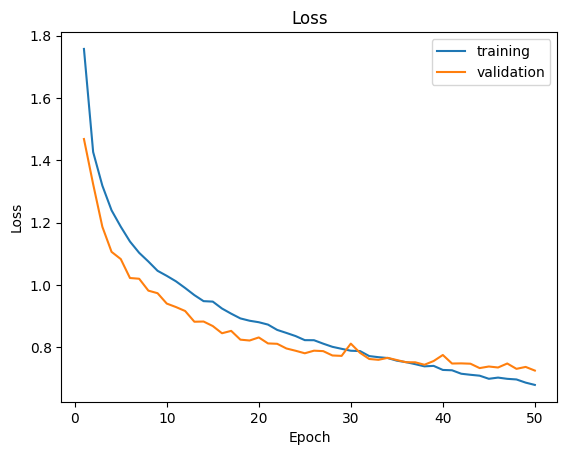

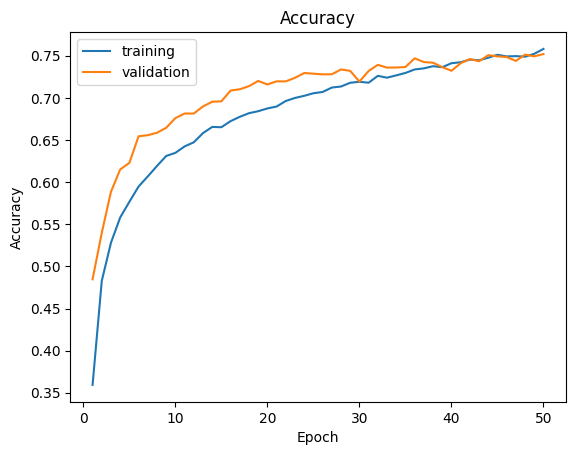

In [13]:
x = np.arange(1, len(train_loss_history)+1, dtype=int)

# Loss 그래프
_, ax = plt.subplots()
ax.plot(x, train_loss_history, label="training")
ax.plot(x, validation_loss_history, label="validation")
ax.set_title('Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

# Accuracy 그래프
_, ax = plt.subplots()
ax.plot(x, train_accuracy_history, label="training")
ax.plot(x, validation_accuracy_history, label="validation")
ax.set_title('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

## 평가
평가에는 test set을 이용한다. 이를 batch size 단위로 불러오기 위해 dataloader를 만든다. 그러나 학습이 아니기 때문에 batch size 단위로 평가할 필요는 없다. 단지, 한 번에 메모리로 불러오는 부담을 줄이기 위해서이다.

**지시: Test accuracy가 70%가 넘도록 모델 및 하이퍼파라미터를 설정한다.**

In [14]:
model.cuda()

testset_loader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False)
test_loss, test_accuracy = test_loop(testset_loader, model, loss_function) # test set을 이용해 평가한다.

print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

Test accuracy: 0.7465, Test loss: 0.7344628175735474


Test set에 있는 일부 이미지 중, 임의로 몇 개 선택해서 예측이 잘 되는지 확인해 본다. 정확도가 높지 않기 때문에, 만족할 만한 결과를 보여주지는 않는다.

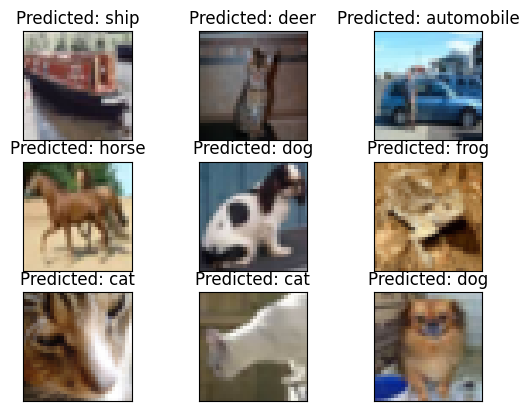

In [15]:
from torch.utils.data import RandomSampler

model.cpu()

_, axes = plt.subplots(3, 3)

for i in range(0, 9):
  random_index = int(np.random.random()*len(testset))
  x, y = dataset[random_index]

  img = np.transpose(x, (1, 2, 0)) # (채널, 세로, 가로) 형태를 (가로, 세로, 채널)로 변환

  x = np.reshape(x, (1, 3, 32, 32))

  model.eval()
  with torch.no_grad(): # 미분을 수행하지 않음
    output = model(x)

  predicted = torch.argmax(output)

  row = i // 3
  col = i % 3
  ax = axes[row, col]

  ax.imshow(img, interpolation='none') # 이미지를 표시한다.
  ax.set_title(f"Predicted: {classes[predicted]}")
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

이번 과제는 여기까지 입니다. 수고하셨습니다.